In [20]:
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from typing import List, Tuple
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import time
import os


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Prepare the data

In [22]:
# Setup Dirs
train_dir ="/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/train/"
test_dir = "/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/test/"
eval_dir = "/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/eval/"

# Setup Workers
NUM_WORKERS = torch.cuda.device_count() if torch.cuda.is_available() else os.cpu_count()
NUM_WORKERS

1

In [23]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [24]:
batch_size = 25

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= NUM_WORKERS)


testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=NUM_WORKERS)

class_names = trainset.classes
print(len(class_names))

198


## Define Conv Neural Network

In [25]:
# class Net(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         # First convolutional layer: takes 3 input channels (RGB images), outputs 6 feature maps,
#         # kernel size of 5x5, stride of 1, and padding of 0 (default)
#         self.conv1 = nn.Conv2d(3, 6, 5)

#         # Max pooling layer: kernel size of 2x2, stride of 2, reduces spatial dimensions by half
#         self.pool = nn.MaxPool2d(2, 2)

#         # Second convolutional layer: takes 6 input channels (from the previous layer), outputs 16 feature maps,
#         # kernel size of 5x5, stride of 1, and padding of 0 (default)
#         self.conv2 = nn.Conv2d(6, 16, 5)

#         # First fully connected (dense) layer: takes flattened input of size 16x53x53 (output from the second conv layer),
#         # outputs 120 features
#         self.fc1 = nn.Linear(16 * 53 * 53, 120)

#         # Second fully connected (dense) layer: takes 120 input features (from the previous layer),
#         # outputs 84 features
#         self.fc2 = nn.Linear(120, 84)

#         # Output layer: takes 84 input features (from the previous layer),
#         # outputs the number of classes specified by num_classes
#         self.fc3 = nn.Linear(84, num_classes)

#     def forward(self, x):
#         # First convolutional layer followed by ReLU activation and max pooling
#         x = self.pool(F.relu(self.conv1(x)))

#         # Second convolutional layer followed by ReLU activation and max pooling
#         x = self.pool(F.relu(self.conv2(x)))

#         # Flatten the output from the previous layer to a 1D tensor
#         x = torch.flatten(x, 1)

#         # First fully connected layer followed by ReLU activation
#         x = F.relu(self.fc1(x))

#         # Second fully connected layer followed by ReLU activation
#         x = F.relu(self.fc2(x))

#         # Output layer (no activation function applied)
#         x = self.fc3(x)
#         return x

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)  # Batch normalization after first conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)  # Batch normalization after second conv layer
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.dropout1 = nn.Dropout(0.5)  # Dropout after first fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)  # Dropout after second fully connected layer
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

num_classes = 198
epochs = 10

# Create an instance of the model
net = Net(num_classes)
net = net.to(device)

In [26]:
# Parameters
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:

# Define your training and testing functions
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total

    return loss, accuracy

def test_step(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total

    return loss, accuracy

In [28]:
# List of criteria and optimizers to try
criteria = [nn.CrossEntropyLoss(), nn.NLLLoss()]
optimizers = [
    optim.SGD(net.parameters(), lr=0.001, momentum=0.9),
    optim.SGD(net.parameters(), lr=0.01, momentum=0.9),
    optim.Adam(net.parameters(), lr=0.001),
    optim.Adam(net.parameters(), lr=0.01)
]

# Initialize lists for storing loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

n_epochs_stop = 2
best_val_loss = np.inf
best_epoch = 0
best_model_state = None

# Initialize figure for live chart
plt.figure()

for criterion in criteria:
    print(f'Criterion: {criterion}')
    for optimizer in optimizers:
        print(f'Optimizer: {optimizer}')
        for epoch in range(epochs):
            start_time = time.time()

            train_loss, train_accuracy = train_step(net, trainloader, criterion, optimizer)
            val_loss, val_accuracy = test_step(net, testloader, criterion)

            end_time = time.time()
            epoch_time = end_time - start_time

            # Early stopping
            if val_loss < best_val_loss:
                epochs_no_improve = 0
                best_val_loss = val_loss
                best_epoch = epoch
                best_model_state = net.state_dict()

            else:
                epochs_no_improve += 1
                if epochs_no_improve == n_epochs_stop:
                    print('Early stopping!')
                    break

            print(f'Epoch {epoch+1}/{epochs}, train loss: {train_loss}, train accuracy: {train_accuracy}, val loss: {val_loss}, val accuracy: {val_accuracy}')
            print(f'Epoch {epoch+1}/{epochs}, epoch time: {epoch_time} seconds')
            print(f'Epoch {epoch+1}/{epochs}, current learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

            # Append loss and accuracy values to lists
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Update live chart
            plt.clf()
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, 'b', label='Training loss')
            plt.plot(val_losses, 'r', label='Validation loss')
            plt.title('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_accuracies, 'b', label='Training accuracy')
            plt.plot(val_accuracies, 'r', label='Validation accuracy')
            plt.title('Accuracy')
            plt.legend()

            plt.pause(0.01)

        if epochs_no_improve == n_epochs_stop:
            break
    if epochs_no_improve == n_epochs_stop:
        break

# After training, you can save the best model state
if best_model_state:
    net.load_state_dict(best_model_state)
    torch.save(net.state_dict(), 'best_model.pth')

Criterion: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 50401) exited unexpectedly

<Figure size 640x480 with 0 Axes>

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int):
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

train(net, trainloader, testloader, optimizer, criterion, epochs)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.2908 | train_acc: 0.5049 | test_loss: 5.2908 | test_acc: 0.5051
Epoch: 2 | train_loss: 5.2908 | train_acc: 0.5049 | test_loss: 5.2908 | test_acc: 0.5051


{'train_loss': [5.290794563513578, 5.29079455960643],
 'train_acc': [0.5049047893825735, 0.5049047893825735],
 'test_loss': [5.290803794475517, 5.290803794475517],
 'test_acc': [0.5050505050505051, 0.5050505050505051]}


Epoch: 1 | train_loss: 5.2908 | train_acc: 0.5049 | test_loss: 5.2908 | test_acc: 0.5051
Epoch: 2 | train_loss: 5.2908 | train_acc: 0.5049 | test_loss: 5.2908 | test_acc: 0.5051
{'train_loss': [5.290794563513578, 5.29079455960643],
 'train_acc': [0.5049047893825735, 0.5049047893825735],
 'test_loss': [5.290803794475517, 5.290803794475517],
 'test_acc': [0.5050505050505051, 0.5050505050505051]}

In [ ]:
model_save_path = '/content/drive/MyDrive/models/models_home_made/net_model.pth'  # Replace with the desired file path
torch.save(net.state_dict(), model_save_path)

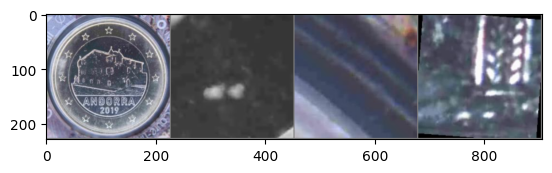

GroundTruth:  Andorre-1-Euro-2019-3250000-157568996679098 Andorre-1-Euro-2019-3250000-157568996679098 Andorre-1-Euro-2019-3250000-157568996679098 Andorre-1-Euro-2019-3250000-157568996679098


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()dataiter = iter(testloader)

images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Monaco-5-Cent-2014-3032850-155539844264374 Monaco-5-Cent-2014-3032850-155539844264374 Monaco-5-Cent-2014-3032850-155539844264374 Monaco-5-Cent-2014-3032850-155539844264374


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %
